<a href="https://colab.research.google.com/github/AaronMichaelMendoza/SED/blob/main/SED_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.datasets import cifar10

# Check if GPU is available
if tf.test.is_gpu_available():
    device = '/GPU:0'
else:
    device = '/CPU:0'

display(device)

# Type into Anaconda to connect locally
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


'/CPU:0'

# Loading Kaggle Datasets Into Google Colab Directory

Only run once

In [ ]:
!pip install kaggle
!mkdir ~/Documents/Semester 8 (Spring 2023)/Senior Design/Google Colab/.kaggle
!cp kaggle.json ~/Documents/Semester 8 (Spring 2023)/Senior Design/Google Colab/.kaggle/
!chmod 600 ~/Documents/Semester 8 (Spring 2023)/Senior Design/Google Colab/.kaggle/kaggle.json

!kaggle datasets download brsdincer/vehicle-detection-image-set
!unzip vehicle-detection-image-set.zip
!kaggle datasets download constantinwerner/human-detection-dataset
!unzip human-detection-dataset.zip
!kaggle datasets download kshitij192/cars-image-dataset
!unzip cars-image-dataset.zip

# Local Runtime Specific


In [14]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas

od.download(
    'https://www.kaggle.com/datasets/kshitij192/cars-image-dataset'
)
od.download(
    'https://www.kaggle.com/datasets/constantinwerner/human-detection-dataset'
)
od.download(
    'https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set'
)

Skipping, found downloaded files in ".\cars-image-dataset" (use force=True to force download)
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: austinwhite21
Your Kaggle Key: ··········


  0%|                                                                                       | 0.00/260M [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████████████████████████████| 260M/260M [01:00<00:00, 4.50MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: austinwhite21
Your Kaggle Key: ··········


  0%|                                                                                       | 0.00/119M [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████████████████████████████| 119M/119M [00:21<00:00, 5.79MB/s]


In [91]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
print(y_train[0:7])

(50000, 32, 32, 3)
(50000, 1)
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]]


# Creating Training and Testing Arrays
Loading Kaggle dataset images into training data, test data, training label, and test labels numpy arrays. This takes a long time to run, so only run once. So, BE CAREFUL with X_train, X_test, Y_train, and Y_test. Altering those arrays means having to rerun this code block. The arrays would be saved to .npz files, but when attempted, the files were half a GB.

The Vehicle/Non-Vehicle data set has the following: 8968 images of non-vehicles and 8792 images of vehicles. Each image is 64x64x3 pixels. Only the non-vehicle images will be used and they will be resized to 320x240x3. 800 images of non-vehicles will be used for training, leaving 80 images for testing.

The Human/Non-Human dataset has the following: 559 images of humans and 362 images of non-humans. Each image has a different resolution, but they are mostly around the desired range. Both sets of data will be used, and each image will be resized to 320x240x3. 500 images of humans will be used in the training data, leaving 59 in the test data. 330 images of non-humans will be used in the training data, leaving 32 for testing.

The Cars Dataset has 3349 images of various cars for training, and 813 images of various cars for testing. Each image has a different resolution, and will be resized to 320x240x3 for training. 100 images from each type of car will be added to the training set, and 10 of each to the testing set. This can be increased if the accuracy needs improvement.


In [2]:
import os, cv2, glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Set to true if running on JupyterLab
# Set to false if running on cloud computing
local_runtime = True

# Image size constants
IMG_SIZE1 = 160
IMG_SIZE2 = 120
IMG_SIZE3 = 3

if(local_runtime == False):
  local_download_path = os.path.expanduser('/content')
  

# Constants that determine how to split the training and testing data
cars_training = 100
cars_testing = 10
human_training = 500
other_training = 330
other_training2 = 800
other_testing2 = 80

# Initializing training data array
if(local_runtime):
  img = Image.open('cars-image-dataset/Cars Dataset/train/Audi/1.jpg')
else:
  img = Image.open('/content/Cars Dataset/train/Audi/1.jpg')
img = img.resize((IMG_SIZE1, IMG_SIZE2), Image.CUBIC)
X_train = np.array(img)[np.newaxis, ...]

# Initialing training label data array, 0 = nothing, 1 = vehicle, 2 = person
Y_train = np.array([[1]])

# Initializng testing data array
if(local_runtime):
  img = Image.open('cars-image-dataset/Cars Dataset/test/Audi/1000.jpg')
else:
  img = Image.open('/content/Cars Dataset/test/Audi/1000.jpg')
img = img.resize((IMG_SIZE1, IMG_SIZE2), Image.CUBIC)
X_test = np.array(img)[np.newaxis, ...]

# Initialing label data array, 0 = nothing, 1 = vehicle, 2 = person
Y_test = np.array([[1]])

# Loading in training data with Cars Dataset images
#print('Loading Cars Dataset')
path = ""
walk_path = ""
if(local_runtime):
  path = "cars-image-dataset/Cars Dataset/train"
  walk_path = path
else:
  path = local_download_path + "/Cars Dataset/train"
  walk_path = 'Cars Dataset/train'

i = 0
for dirpath, dirnames, filenames in os.walk(walk_path):
  for dirname in dirnames:
    #print('Adding', dirname, 'to training data')
    local_path = path +  '/' + dirname + '/*.jpg'
    i = 0
    for file in glob.glob(local_path):
      img = Image.open(file)
      img = img.resize((IMG_SIZE1, IMG_SIZE2), Image.CUBIC)
      if(np.array(img).shape == (IMG_SIZE2,IMG_SIZE1,IMG_SIZE3)):
        if(i < cars_training):
          X_train = np.vstack((X_train, np.array(img)[np.newaxis, ...]))
          Y_train = np.vstack((Y_train, [1]))
          i = i + 1
  
#print('X_train current shape: ', X_train.shape)
#print('Y_train current shape: ', Y_train.shape)

# Loading in test data with Cars Dataset images
if(local_runtime):
  path = "cars-image-dataset/Cars Dataset/test"
  walk_path = path
else:
  path = local_download_path + "/Cars Dataset/test"
  walk_path = 'Cars Dataset/test'

for dirpath, dirnames, filenames in os.walk(walk_path):
  for dirname in dirnames:
    #print('Adding', dirname, 'to test data')
    local_path = path +  '/' + dirname + '/*.jpg'
    i = 0
    for file in glob.glob(local_path):
        img = Image.open(file)
        img = img.resize((IMG_SIZE1, IMG_SIZE2), Image.CUBIC)
        if(np.array(img).shape == (IMG_SIZE2,IMG_SIZE1,IMG_SIZE3)):
          if(i < cars_testing):
            X_test = np.vstack((X_test, np.array(img)[np.newaxis, ...]))
            Y_test = np.vstack((Y_test, [1]))
            i = i + 1
#print('X_test current shape: ', X_test.shape)
#print('Y_test current shape: ', Y_test.shape)

# Loading Human Detection Dataset into training and test data
#print('Loading Human Detection Dataset')
if(local_runtime):
  path = "human-detection-dataset/human detection dataset/0/*.png"
else:
  path = local_download_path + "/human detection dataset/0/*.png"

i = 0
for file in glob.glob(path):
    img = Image.open(file)
    img = img.resize((IMG_SIZE1, IMG_SIZE2), Image.CUBIC)
    if(np.array(img).shape == (IMG_SIZE2,IMG_SIZE1,IMG_SIZE3)):
      if(i < other_training):
        X_train = np.vstack((X_train, np.array(img)[np.newaxis, ...]))
        Y_train = np.vstack((Y_train, [0]))
      else:
        X_test = np.vstack((X_test, np.array(img)[np.newaxis, ...]))
        Y_test = np.vstack((Y_test, [0]))
    i = i + 1
#print('X_train current shape: ', X_train.shape)
#print('Y_train current shape: ', Y_train.shape)
#print('X_test current shape: ', X_test.shape)
#print('Y_test current shape: ', Y_test.shape)
if(local_runtime):
  path = "human-detection-dataset/human detection dataset/1/*.png"
else:
  path = local_download_path + "/human detection dataset/1/*.png"

i = 0
for file in glob.glob(path):
    img = Image.open(file)
    img = img.resize((IMG_SIZE1, IMG_SIZE2), Image.CUBIC)
    if(np.array(img).shape == (IMG_SIZE2,IMG_SIZE1,IMG_SIZE3)):
      if(i < human_training):
        X_train = np.vstack((X_train, np.array(img)[np.newaxis, ...]))
        Y_train = np.vstack((Y_train, [2]))
      else:
        X_test = np.vstack((X_test, np.array(img)[np.newaxis, ...]))
        Y_test = np.vstack((Y_test, [2]))
    i = i + 1
#print('X_train current shape: ', X_train.shape)
#print('Y_train current shape: ', Y_train.shape)
#print('X_test current shape: ', X_test.shape)
#print('Y_test current shape: ', Y_test.shape)

# Loading Vehicle Dataset into training and test data
#print('Loading Vehicle Dataset')
if(local_runtime):
  path = "vehicle-detection-image-set/data/non-vehicles/*.png"
else:
  path = local_download_path + "/data/non-vehicles/*.png"
i = 0
for file in glob.glob(path):
    img = Image.open(file)
    img = img.resize((IMG_SIZE1,IMG_SIZE2), Image.CUBIC)
    if(np.array(img).shape == (IMG_SIZE2,IMG_SIZE1,IMG_SIZE3)):
      if(i < other_training2):
        X_train = np.vstack((X_train, np.array(img)[np.newaxis, ...]))
        Y_train = np.vstack((Y_train, [0]))
        i = i + 1
      elif(i < (other_training2 + other_testing2)):
        X_test = np.vstack((X_test, np.array(img)[np.newaxis, ...]))
        Y_test = np.vstack((Y_test, [0]))
        i = i + 1

# Should be (2271, IMG_SIZE2, IMG_SIZE1, IMG_SIZE3)
print('X_train shape: ', X_train.shape)
# Should be (2271, 1)
print('Y_train shape: ', Y_train.shape)
# Should be (240, IMG_SIZE2, IMG_SIZE1, IMG_SIZE3)
print('X_test shape: ', X_test.shape)
# Should be (240, 1)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (2271, 120, 160, 3)
Y_train shape:  (2271, 1)
X_test shape:  (240, 120, 160, 3)
Y_test shape:  (240, 1)


1925 [0]


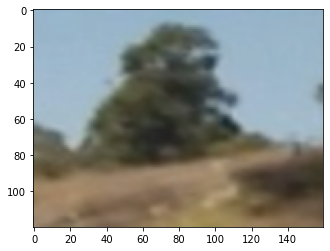

In [3]:
import random
r = random.randint(0,len(X_train))
plt.imshow(X_train[r])
print(r, Y_train[r])

In [5]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

NameError: ignored

In [6]:
# Normalize pixel values to the range [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2271, 120, 160, 3)
(2271, 1)
(240, 120, 160, 3)
(240, 1)


# CNN Architecture

In [12]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE2, IMG_SIZE1, IMG_SIZE3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 118, 158, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 59, 79, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 57, 77, 32)        9248      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 28, 38, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 26, 36, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 13, 18, 64)      

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=30, 
                    validation_data=(X_test, Y_test))

Epoch 1/30


C:\Users\arw_2\anaconda3\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/71 [==============================] - 36s 455ms/step - loss: 0.8240 - accuracy: 0.6592 - val_loss: 0.6517 - val_accuracy: 0.7167
Epoch 2/30
71/71 [==============================] - 31s 439ms/step - loss: 0.5852 - accuracy: 0.7530 - val_loss: 0.5570 - val_accuracy: 0.7875
Epoch 3/30
71/71 [==============================] - 31s 440ms/step - loss: 0.5033 - accuracy: 0.7948 - val_loss: 0.6461 - val_accuracy: 0.7292
Epoch 4/30
71/71 [==============================] - 31s 439ms/step - loss: 0.5145 - accuracy: 0.7807 - val_loss: 0.5157 - val_accuracy: 0.7917
Epoch 5/30
71/71 [==============================] - 32s 447ms/step - loss: 0.4651 - accuracy: 0.8146 - val_loss: 0.4573 - val_accuracy: 0.8167
Epoch 6/30
71/71 [==============================] - 31s 430ms/step - loss: 0.4068 - accuracy: 0.8322 - val_loss: 0.4438 - val_accuracy: 0.8292
Epoch 7/30
71/71 [==============================] - 31s 430ms/step - loss: 0.3712 - accuracy: 0.8463 - val_loss: 0.5544 - val_accuracy: 0.7583
Epoch 8/30

In [14]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print(test_acc)

8/8 - 1s - loss: 0.8507 - accuracy: 0.8125 - 587ms/epoch - 73ms/step
0.8125


2107 [0]
1/1 [==============================] - 0s 49ms/step
The models predicts nothing with 99.99974966049194 % certainty


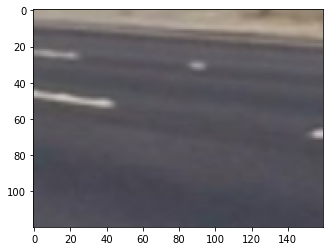

In [23]:
# Plot some random predictions

import random

r = random.randint(0,len(X_train))
plt.imshow(X_train[r])
print(r, Y_train[r])
prediction = model.predict(X_train[r][np.newaxis,...])
pred_label = np.argmax(prediction)
class_names = ['nothing', 'car', 'person']
print('The models predicts', class_names[pred_label], 'with', prediction[0][pred_label] * 100, '% certainty')

1/1 [==============================] - 0s 215ms/step
[[0. 0. 1.]]
The model predicts person with 100.0 % certainty


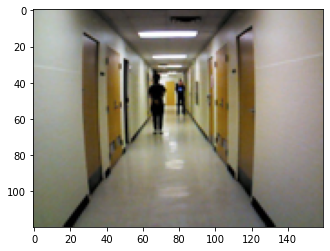

In [24]:
img = Image.open('Documents/Semester 8 (Spring 2023)/Senior Design/3050.jpg')
img = img.resize((IMG_SIZE1, IMG_SIZE2), Image.CUBIC)

plt.imshow(img)
prediction = model.predict(np.array(img)[np.newaxis,...])
print(prediction)
pred_label = np.argmax(prediction)
class_names = ['nothing', 'car', 'person']
print('The model predicts', class_names[pred_label], 'with', prediction[0][pred_label] * 100, '% certainty')

In [25]:
# Save model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('Documents/Semester 8 (Spring 2023)/Senior Design/Google Colab/SED-model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\arw_2\AppData\Local\Temp\tmpez0i6luj\assets


INFO:tensorflow:Assets written to: C:\Users\arw_2\AppData\Local\Temp\tmpez0i6luj\assets


# Transfer Learning with ResNet



In [6]:
# Type below into Anaconda 
#conda install -c anaconda tensorflow-datasets

!pip install tensorflow_datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

keras = tf.keras

In [7]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.resnet.ResNet50(include_top=False,
                                               weights='imagenet',
                                               input_shape=(240,320,3))

94765736/94765736 [==============================] - 18s 0us/step


In [8]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [12]:
prediction_layer = keras.layers.Dense(3)

In [13]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 10, 2048)       23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
validation_steps=20
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
initial_epochs = 10

history = model.fit(X_train, Y_train, epochs=8, 
                    validation_data=(X_test, Y_test))

acc = history.history['accuracy']
print(acc)

Epoch 1/8
71/71 [==============================] - 256s 4s/step - loss: 1.0230 - accuracy: 0.4826 - val_loss: 1.0244 - val_accuracy: 0.4792
Epoch 2/8
71/71 [==============================] - 269s 4s/step - loss: 0.9770 - accuracy: 0.5280 - val_loss: 0.9992 - val_accuracy: 0.4875
Epoch 3/8
71/71 [==============================] - 253s 4s/step - loss: 0.9421 - accuracy: 0.5716 - val_loss: 0.9617 - val_accuracy: 0.5667
Epoch 4/8
71/71 [==============================] - 251s 4s/step - loss: 0.9131 - accuracy: 0.6006 - val_loss: 0.9294 - val_accuracy: 0.5833
Epoch 5/8
71/71 [==============================] - 256s 4s/step - loss: 0.8879 - accuracy: 0.6213 - val_loss: 0.9110 - val_accuracy: 0.5875
Epoch 6/8
71/71 [==============================] - ETA: 0s - loss: 0.8657 - accuracy: 0.6380

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_batches)
print(test_acc)

# VGG Architecture

In [7]:
# Define the VGG model architecture
with tf.device(device):
  model = keras.Sequential(
      [
          # Convolutional layers
          layers.Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(240, 320, 3)),
          layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
          layers.MaxPooling2D((2, 2)),
          layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
          layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
          layers.MaxPooling2D((2, 2)),
          layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
          layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
          layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
          layers.MaxPooling2D((2, 2)),
          layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
          layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
          layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
          layers.MaxPooling2D((2, 2)),
          layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
          layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
          layers.Conv2D(512, (3, 3), activation="relu", padding="same"),
          layers.MaxPooling2D((2, 2)),
          # Dense layers
          layers.Flatten(),
          layers.Dense(4096, activation="relu"),
          layers.Dense(4096, activation="relu"),
          layers.Dense(10, activation="softmax"),
       ]
      )
  
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 320, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 320, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 160, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 160, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 160, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 80, 128)      0         
 2D)                                                    

In [8]:
# Compile the model
with tf.device(device):
  model.compile(
      optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
      )

In [ ]:
# Train the model
with tf.device(device):
  history = model.fit(X_train, Y_train, epochs=2, batch_size=64, validation_split=0.1)

Epoch 1/2


In [ ]:
# Evaluate the model on the test set
with tf.device(device):
  test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get predicted labels for the test set
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Define class names for CIFAR-10 dataset
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# Create a figure with 16 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()

# Plot images with their predicted labels
for i in range(16):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPred: %s" % (class_names[y_test[i][0]], 
                                                class_names[y_pred_labels[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1, hspace=1)
plt.show()